In [31]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:

test = pd.read_csv('../Kaggle Toxic Comment Classification Challenge/input/test.csv')
test_labels = pd.read_csv('../Kaggle Toxic Comment Classification Challenge/test_labels.csv')

display(test.head())
display(test_labels.head())

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [3]:
# Step 1: Filter out rows in `test_labels` where `toxic` is -1 
# Keep only samples with available labels
filtered_test_labels = test_labels[test_labels['toxic'] != -1]

# Step 2: Get the corresponding IDs that remain after filtering
valid_ids = filtered_test_labels['id']

# Step 3: Filter `test` DataFrame to keep only rows with IDs in `valid_ids`
filtered_test = test[test['id'].isin(valid_ids)]

# Now, `filtered_test` and `filtered_test_labels` are synchronized
# Save them back if needed
test = filtered_test
test_labels = filtered_test_labels

display(test.head())
display(test_labels.head())

print(test.shape + test_labels.shape)

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \r\n\r\n It says it right there that it IS a..."
14,00059ace3e3e9a53,""" \r\n\r\n == Before adding a new product to t..."


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0


(63978, 2, 63978, 7)


5         thank you for understanding. i think very high...
7                          :dear god this site is horrible.
11        "::: somebody will invariably try to add relig...
13        "  it says it right there that it is a type. t...
14        "  == before adding a new product to the list,...
                                ...                        
153150    :jerome, i see you never got around to this…! ...
153151    ==lucky bastard==  http://wikimediafoundation....
153154    ==shame on you all!!!==  you want to speak abo...
153155    mel gibson is a nazi bitch who makes shitty mo...
153156    "  == unicorn lair discovery ==  supposedly, a...
Name: comment_text, Length: 63978, dtype: object


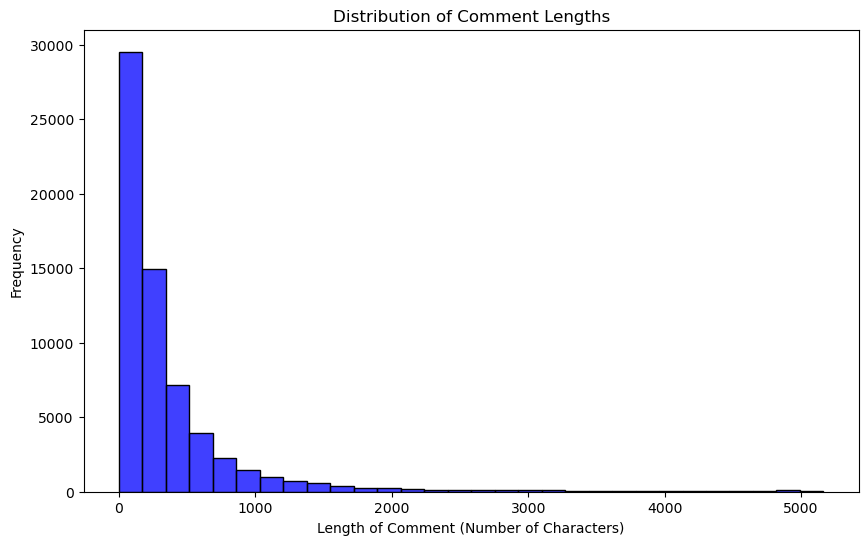

In [32]:
samples = test['comment_text']
y = test_labels['toxic']

# Replace NaN values with an empty string
samples = test['comment_text'].fillna('')
# Convert all entries to string
samples = samples.astype(str)
# Remove control characters
samples = samples.apply(lambda x: ''.join(c for c in x if c.isprintable()))
# Lowercase and remove leading/trailing whitespaces
samples = samples.apply(lambda x: x.lower().strip())

print(samples)

# Calculate the length of each string in the 'samples' list
lengths = samples.apply(len)

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(lengths, kde=False, bins=30, color='blue')  # Adjust bins as needed
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comment (Number of Characters)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

# autopilot-ai/EthicalEye

In [5]:
# autopilot-ai/EthicalEye

model = AutoModelForSequenceClassification.from_pretrained("autopilot-ai/EthicalEye")
tokenizer = AutoTokenizer.from_pretrained("autopilot-ai/EthicalEye")

In [40]:
# test set size is 63978, computation time too long on my computer
test_set_size = 100

# Define the non-safe labels you are interested in
non_safe_labels = {"Un-Safe"} 

# Maximum length of a tokens
MAX_LENGTH = 200

# List to store predictions for each comment
predictions = []

# Iterate over each comment in samples
for comment in samples:
    # Tokenize the input
    inputs = tokenizer(comment, return_tensors="pt", max_length=MAX_LENGTH, truncation=True)

    # Get model outputs
    outputs = model(**inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Apply softmax to get probabilities (scores)
    probabilities = logits.softmax(dim=-1).squeeze()
    
    # Retrieve the labels
    id2label = model.config.id2label
    labels = [id2label[idx] for idx in range(len(probabilities))]
    
    # Initialize the maximum probability for non-safe labels
    max_non_safe_prob = 0.0
    
    # Find the highest probability of non-safe label(s)
    for label, probability in zip(labels, probabilities):
        if label in non_safe_labels and probability.item() > max_non_safe_prob:
            max_non_safe_prob = probability.item()

    # Store the comment and non-safe probability
    predictions.append({"comment": comment, "non_safe_probability": max_non_safe_prob})

    if len(predictions) == test_set_size:
        break

# Convert predictions to a DataFrame (optional)
predictions_df = pd.DataFrame(predictions)

# Print the DataFrame
print(predictions_df)


                                              comment  non_safe_probability
0   thank you for understanding. i think very high...              0.000263
1                    :dear god this site is horrible.              0.259078
2   "::: somebody will invariably try to add relig...              0.831513
3   "  it says it right there that it is a type. t...              0.003455
4   "  == before adding a new product to the list,...              0.000275
..                                                ...                   ...
95  "  p.s. imho, this all falls under the categor...              0.001478
96                      redirect talk:ponhook lake 10              0.000197
97  "  ===use of ""nepal bhasa""===  the term ""ne...              0.002550
98  if the indigenous population is so low why do ...              0.025275
99                              and lewd sex in china              0.989991

[100 rows x 2 columns]


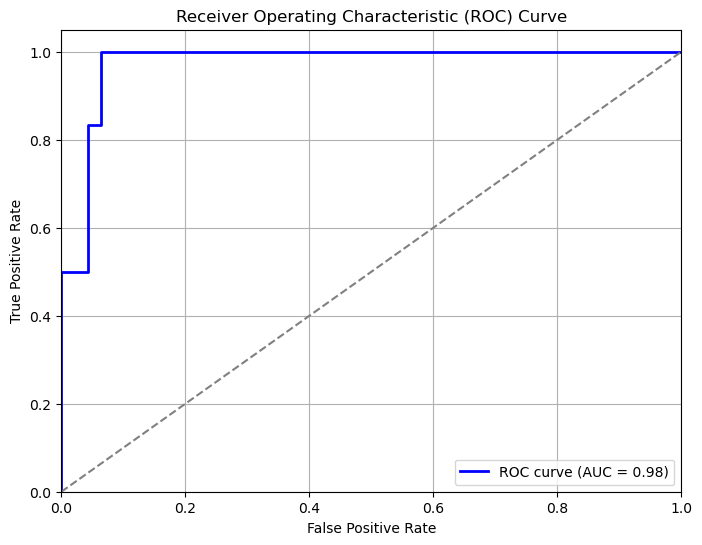

In [41]:
# y_true should be a 1D array of true binary labels (0 or 1)
# y_pred should be a 1D array of predicted probabilities or scores (continuous values between 0 and 1)
y_true = test_labels['toxic'][:test_set_size]  # ground truth labels
y_pred = predictions_df['non_safe_probability']  # predicted probabilities or scores

# 1. Compute ROC curve data points
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# 2. Compute the AUC
roc_auc = auc(fpr, tpr)

# 3. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
